# Computer Vision, Spring 2023 HW1
B11705009 An-Che, Liang

## Part1: Difference of Gaussian

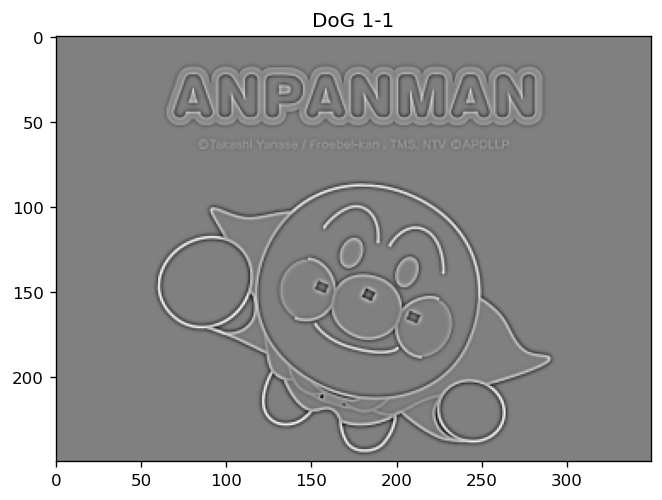

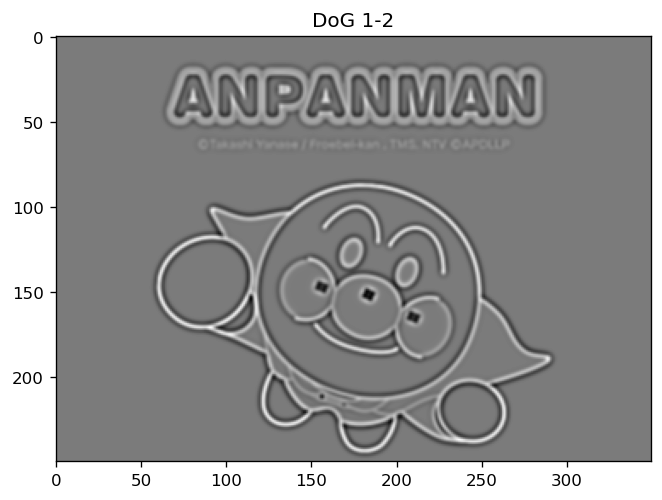

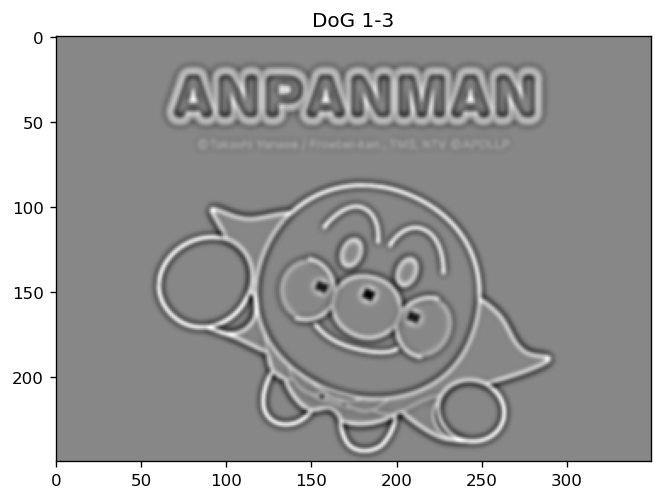

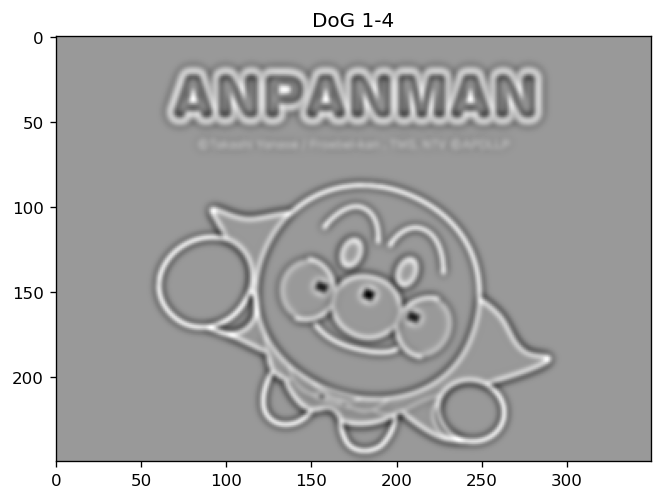

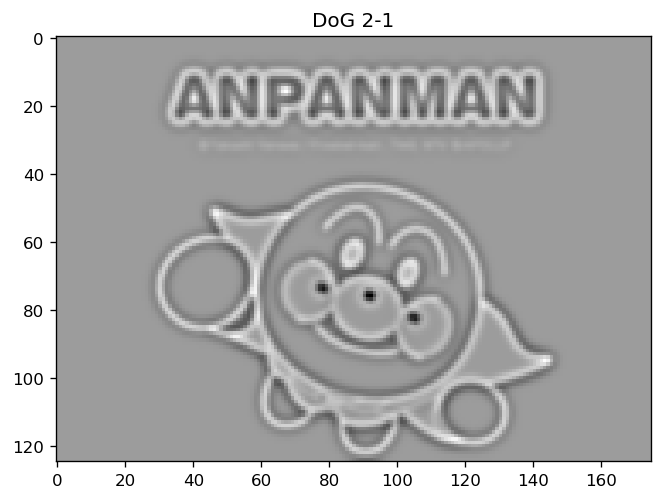

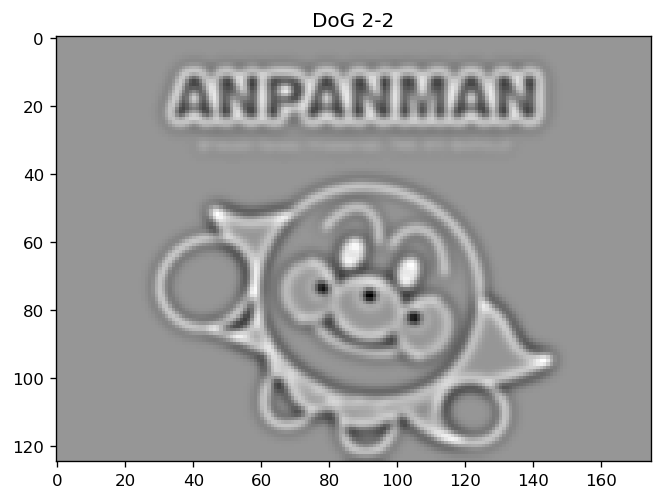

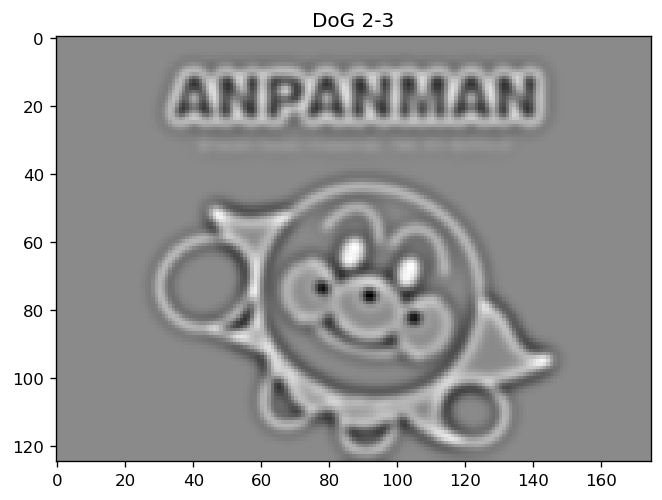

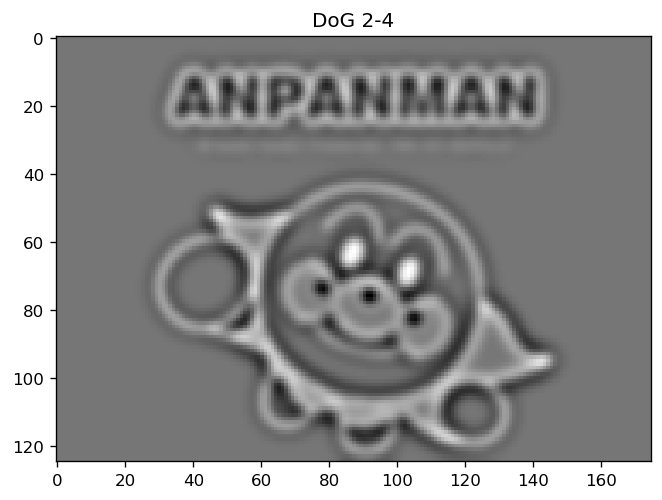

In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
DoG_img = cv2.imread("./part1/testdata/1.png", 0).astype(np.float32)
num_DoG_images_per_octave = 4
num_guassian_images_per_octave = num_DoG_images_per_octave + 1
sigma = 2**(1/4)


def get_octave_blur(source):
    result = [source.copy()]
    for i in range(1, num_guassian_images_per_octave):
        result.append(cv2.GaussianBlur(source, ksize=(0, 0),
                      sigmaX=sigma**i, sigmaY=sigma**i))
    return result


blurred_images = []
blurred_images.append(get_octave_blur(DoG_img))
resized_last_image = cv2.resize(
    blurred_images[-1][-1], (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)
blurred_images.append(get_octave_blur(resized_last_image))
dog_images = []
for octave in blurred_images:
    dog_images.append([])
    for i in range(len(octave) - 1):
        dog_images[-1].append(cv2.subtract(octave[i+1], octave[i]))

for i,  octave in enumerate(dog_images):
    for k, image in enumerate(octave):
        plt.figure()
        plt.title(f"DoG {i+1}-{k+1}")
        plt.imshow(image, cmap='gray')


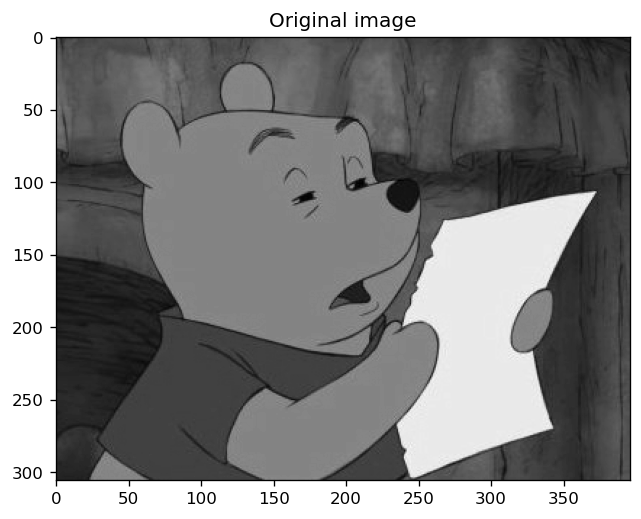

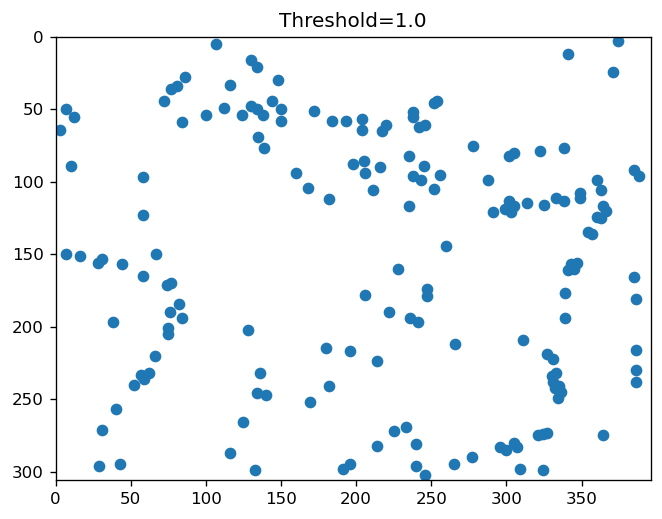

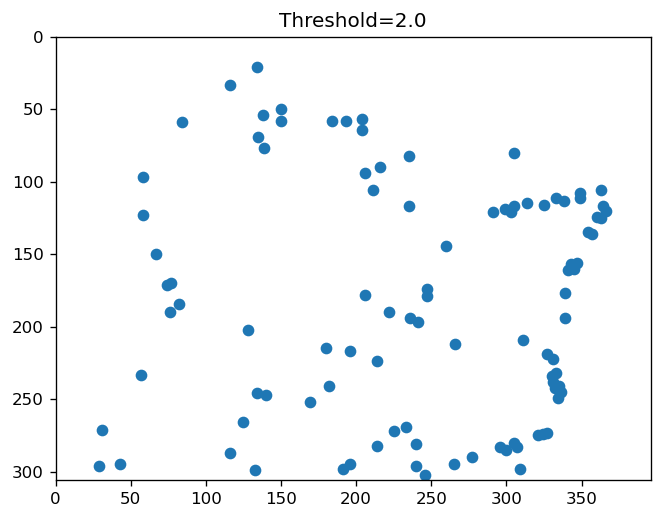

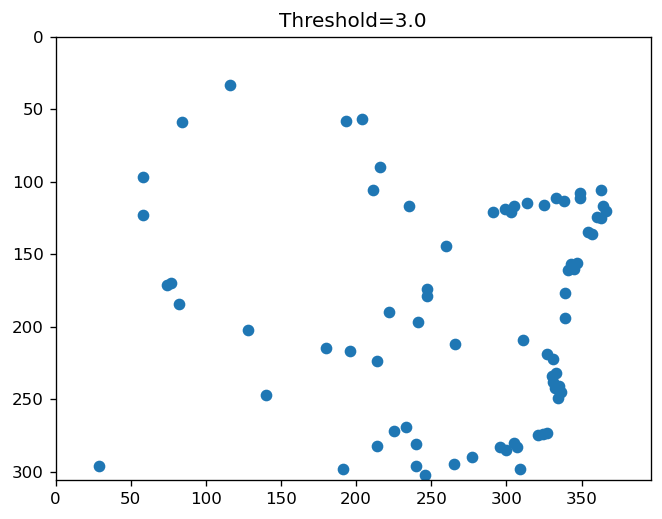

In [46]:
from part1.DoG import Difference_of_Gaussian
img = cv2.imread("./part1/testdata/2.png", 0).astype(np.float64)
plt.figure()
plt.title("Original image")
plt.imshow(img, cmap="gray")

for threshold in [1.0, 2.0, 3.0]:
    DoG = Difference_of_Gaussian(threshold)
    keypoints = DoG.get_keypoints(img)
    plt.figure()
    plt.xlim(0, img.shape[1])
    plt.ylim(0, img.shape[0])
    plt.gca().invert_yaxis()
    plt.scatter(keypoints[:, 1], keypoints[:, 0])
    plt.title(f"Threshold={threshold}")


We can see that when $\text{threshold} =1.0$, the Difference of Gaussian algorithm captures a lot of unecessary edges (dark lines in the back ground). When $\text{threshold} =2.0$, the algorithm capture the edges of winnie very well, the keypoints resemble the original shape. When $\text{threshold} =3.0$, since the threshold is really high, the algorithm ignores a lot of extreme points, so we cannot clearly identify the shape of winnie (e.g. the right shoulder of winnie is gone).

## Part2: Joint bilateral filter

### (a)

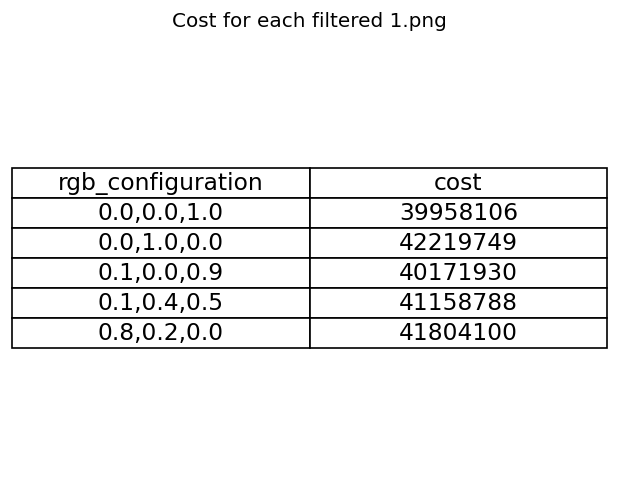

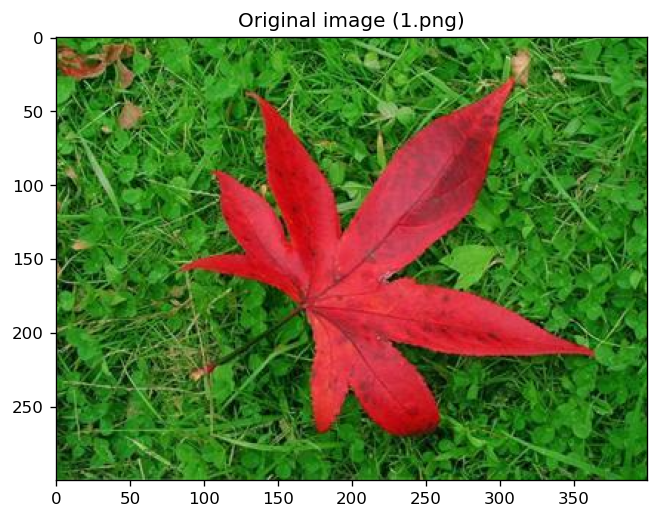

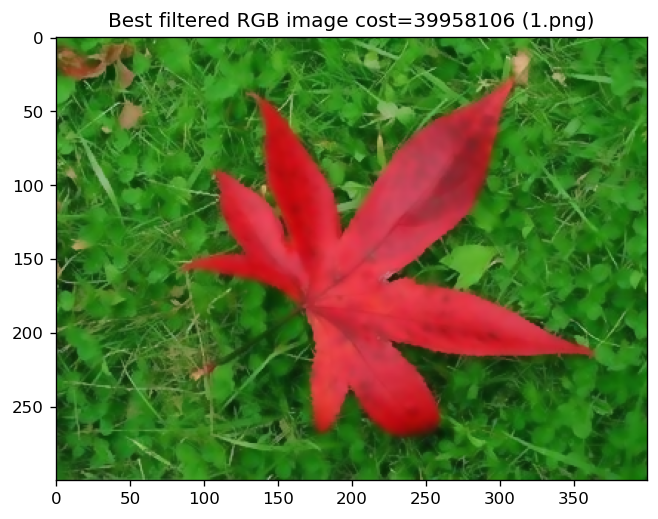

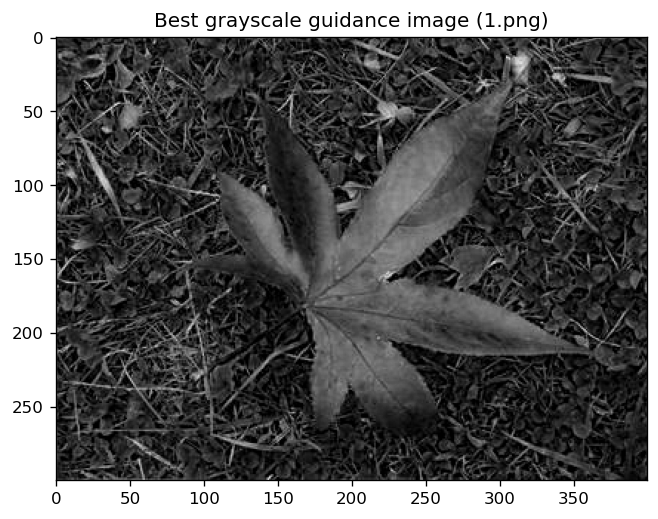

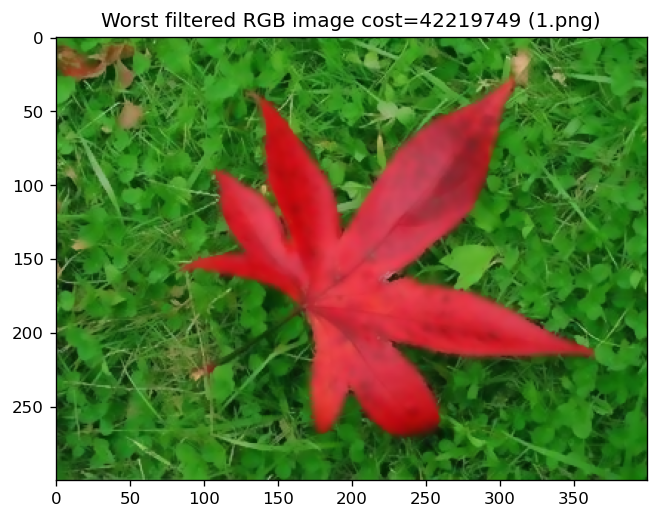

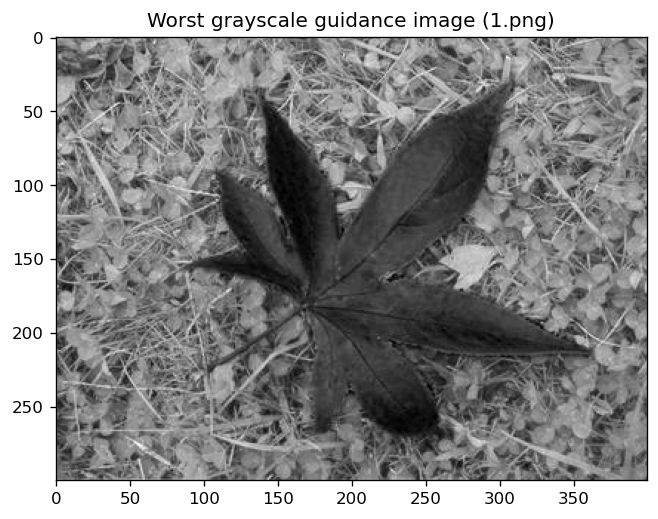

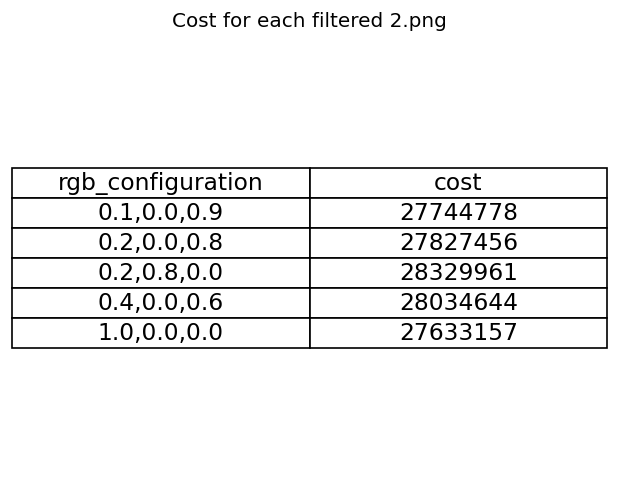

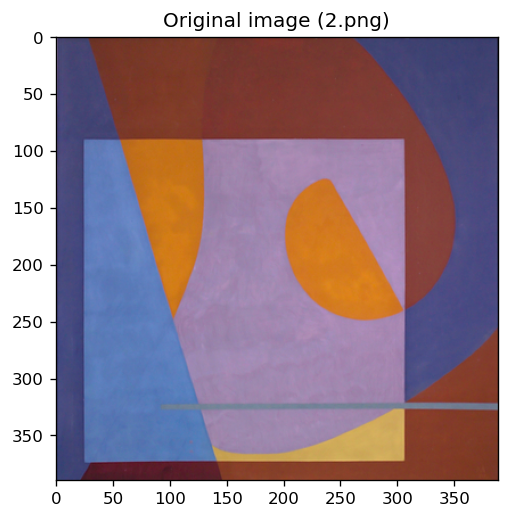

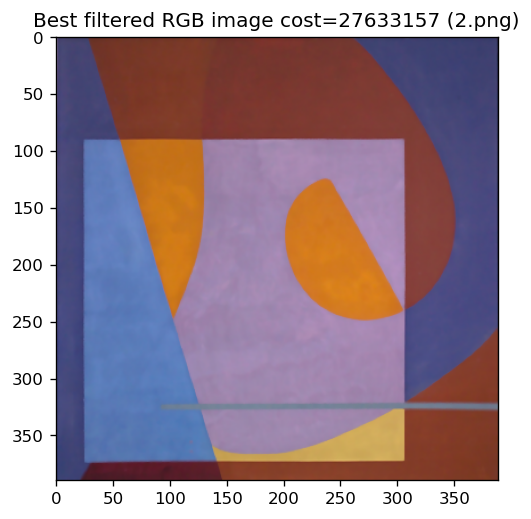

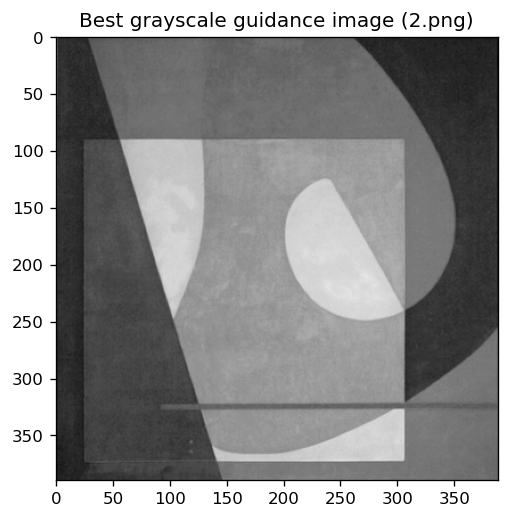

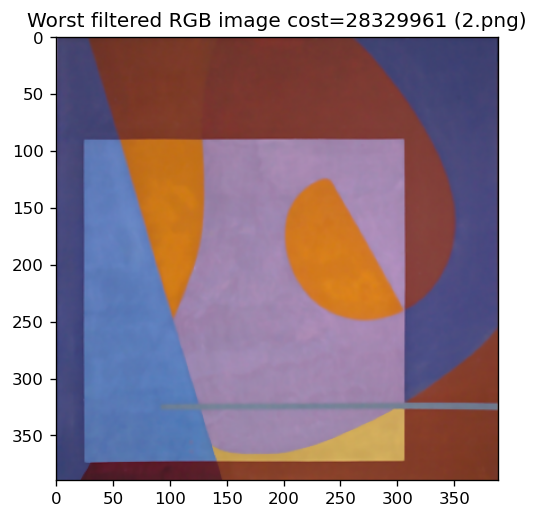

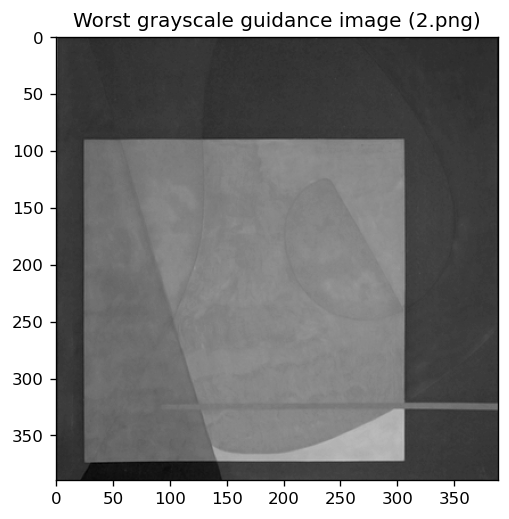

In [47]:
from part2.JBF import Joint_bilateral_filter
from IPython.display import display
import pandas as pd
for image_name in ["1", "2"]:
    original_image = cv2.imread(f"./part2/testdata/{image_name}.png")
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    with open(f"./part2/testdata/{image_name}_setting.txt") as config_file:
        config_data = list(map(lambda x: x.split(
            ","), config_file.read().split("\n")))
    rgb_settings = [[float(val) for val in setting]
                    for setting in config_data[1:6]]
    sigma_s = float(config_data[6][1])
    sigma_r = float(config_data[6][3])
    JBF = Joint_bilateral_filter(int(sigma_s), sigma_r)
    original_filtered_image = JBF.joint_bilateral_filter(
        original_image, original_image).astype(np.uint8)
    gray_scale_images = []
    filtered_images = []
    for rgb_setting in rgb_settings:
        gray_scale_images.append(cv2.transform(
            original_image, np.array(rgb_setting).reshape((1, 3))))
        filtered_images.append(JBF.joint_bilateral_filter(
            original_image, gray_scale_images[-1]).astype(np.uint8))
    cost = np.array([np.sum(np.abs(original_image - filtered_image))
                     for filtered_image in filtered_images])
    best_filter_index = np.argmin(cost)
    worst_filter_index = np.argmax(cost)
    df = pd.DataFrame({"rgb_configuration": [",".join(
        [str(val)for val in setting]) for setting in rgb_settings], "cost": cost})
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=list(
        df.columns), loc='center', cellLoc='center')
    table.set_fontsize(14)
    table.scale(1, 1.5)
    plt.title(f"Cost for each filtered {image_name}.png")
    plt.show()
    plt.figure()
    plt.title(f"Original image ({image_name}.png)")
    plt.imshow(original_image)
    plt.figure()
    plt.title(
        f"Best filtered RGB image cost={cost[best_filter_index]} ({image_name}.png)")
    plt.imshow(filtered_images[best_filter_index])
    plt.figure()
    plt.title(f"Best grayscale guidance image ({image_name}.png)")
    plt.imshow(gray_scale_images[best_filter_index], cmap="gray")
    plt.figure()
    plt.title(
        f"Worst filtered RGB image cost={cost[worst_filter_index]} ({image_name}.png)")
    plt.imshow(filtered_images[worst_filter_index])
    plt.figure()
    plt.title(f"Worst grayscale guidance image ({image_name}.png)")
    plt.imshow(gray_scale_images[worst_filter_index], cmap="gray")


1. For image 1.jpg, we can see that with the configuration of $Y=1.0G$ yield the highest cost, and $Y=1.0B$ yield the lowest cost. Since the background color of the image is green, so if we use the green channel to capture the edges of the image (as guidance image for Joint bilateral filter), the algorithm cannot identify the edges between two leaves, cause the cost to increase. While if we use $Y=1.0B$, we can see that the gray scale image better capture the edges of different leaves in the background.
2. For image 2.jpg, we can see that with the configuration of $Y=0.2R+0.8G$ yield the highest cost, and $Y=1.0R$ yield the lowest cost. We can again observe that the best gray scale guidance image better capture the edges of the origanal image, while with the worst guidance image, we can barely see the edges of different color blocks in the middle.

### (b)